**Import the required libraries**

In [103]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pickle

import warnings
warnings.filterwarnings('ignore')

**read csv file and print the dataset information**

In [104]:
# Load Data of csv into dataframe
df = pd.read_csv("prepared_iot_data.csv")
print("Initial Data Info:")
print(df.info())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24274 entries, 0 to 24273
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     24274 non-null  object 
 1   unix_timestamp           24274 non-null  int64  
 2   tempreature              24274 non-null  int64  
 3   humidity                 24274 non-null  int64  
 4   hour                     24274 non-null  int64  
 5   day_of_week              24274 non-null  int64  
 6   month                    24274 non-null  int64  
 7   year                     24274 non-null  int64  
 8   tempreature_lag1         24274 non-null  float64
 9   humidity_lag1            24274 non-null  float64
 10  N                        24274 non-null  int64  
 11  Fan_actuator             24274 non-null  int64  
 12  Watering_plant_pump      24274 non-null  int64  
 13  Water_pump_actuator      24274 non-null  int64  
 14  wat

**Converting date datatype and setting it as index**

In [105]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

**resample the whole dataset in hourly data**

In [106]:
# Resample to hourly data
df_resampled = df.resample('H').mean()

**Plot the soil nutrient against date**

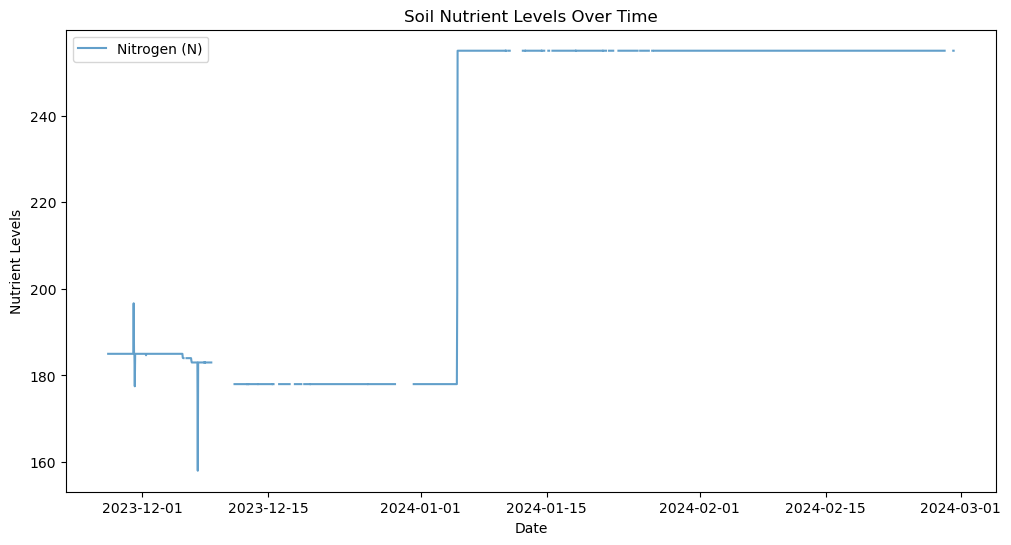

In [107]:
# Plot the Nutrient Levels
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['N'], label='Nitrogen (N)', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Nutrient Levels")
plt.title("Soil Nutrient Levels Over Time")
plt.legend()
plt.show()

**Function to get adf and padf values and plotting those values**

Stationarity Test for K (Before Differencing): False
Stationarity Test for K (After Differencing): True


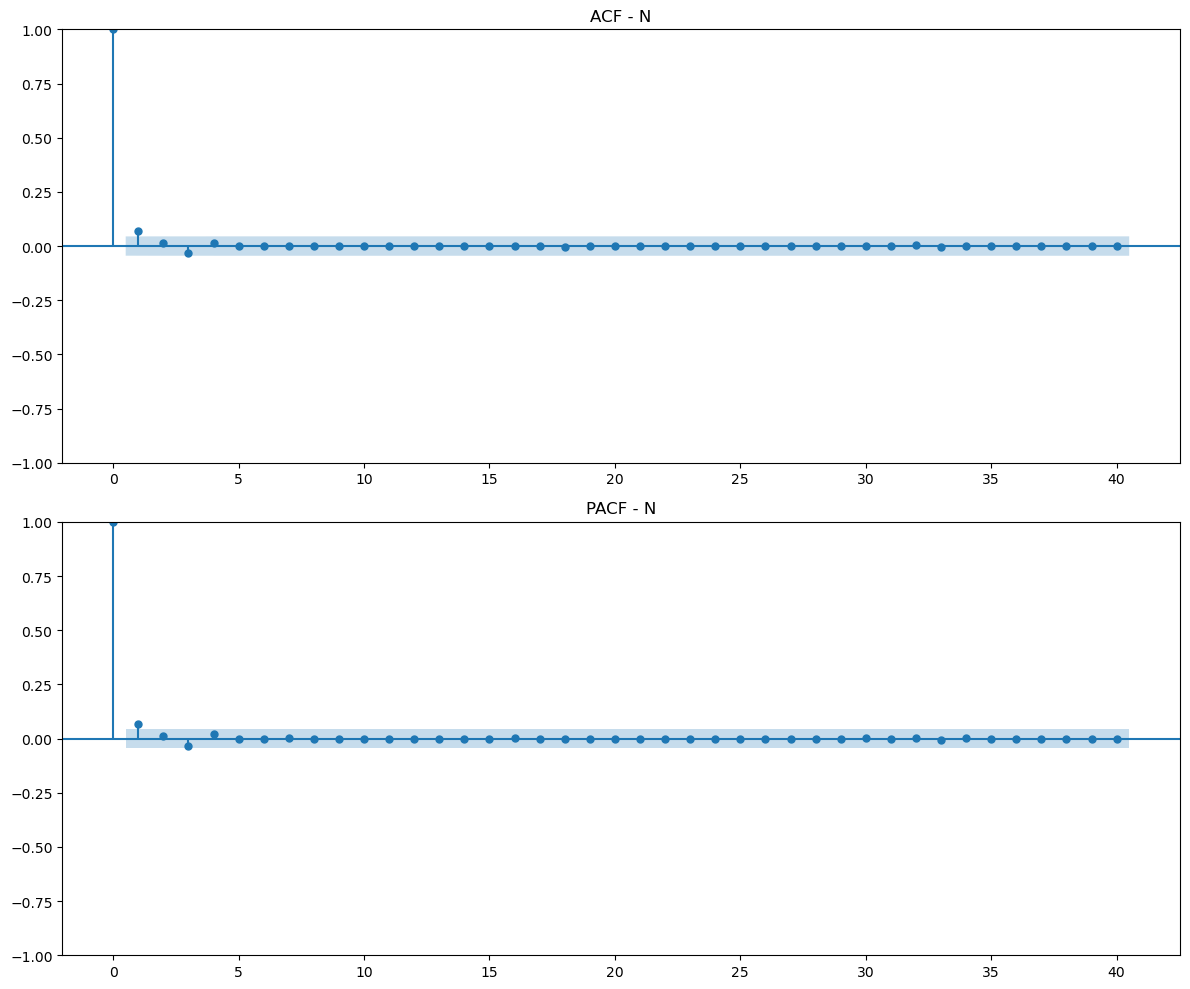

In [108]:
# Check Stationarity using ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # True if Stationary
    
# retrieving the stationarity test for N
print(f"Stationarity Test for {col} (Before Differencing):", adf_test(df_resampled['N']))

# Apply First-Order Differencing
df_diff = df_resampled.diff().dropna()
print(f"Stationarity Test for {col} (After Differencing):", adf_test(df_diff['N']))

# Plot ACF & PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff['N'], ax=axes[0], lags=40, title=f"ACF - {'N'}")
plot_pacf(df_diff['N'], ax=axes[1], lags=40, title=f"PACF - {'N'}")
plt.tight_layout()
plt.show()

**Declaring the Exogenorous Variables**

In [109]:
# Define Exogenous Variables
exog_vars = ['tempreature', 'water_level']
exog_data = df_resampled[exog_vars].dropna()

**SARIMAX model Fitting and Saving the model**

In [110]:
# Fit SARIMAX Model for All Nutrients
forecast_steps = 24
forecast_results = {}
rmse_results = {}

df_change = df_resampled['N'].reindex(exog_data.index)
df_target = df_resampled['N'].loc[exog_data.index]
sarimax_model = SARIMAX(df_target, exog=exog_data, order=(2,1,2), seasonal_order=(2,1,2,12))
sarimax_result = sarimax_model.fit(disp=False)
 # Save model
with open(f"sarimax_N.pkl", "wb") as model_file:
    pickle.dump(sarimax_result, model_file)

**Loading and Predicting the Saved Model**

In [111]:
# load and forecast the results of the model

with open(f"sarimax_N.pkl", "rb") as model_file:
    sarimax_result = pickle.load(model_file)
forecast = sarimax_result.get_forecast(steps=forecast_steps, exog=exog_data.iloc[-forecast_steps:])
forecast_results['N'] = forecast.predicted_mean
rmse_results['N'] = np.sqrt(mean_squared_error(df_target[-forecast_steps:], forecast_results['N']))

 **Plotting the actual and predicted values**

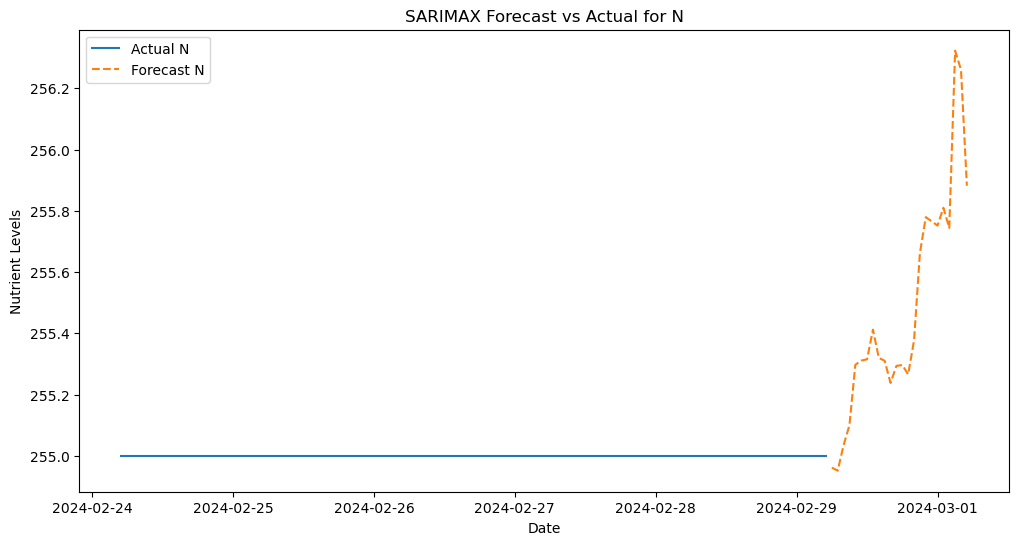

In [112]:
# Setting the predicted values index to datetime
last_timestamp = df_target.index[-1]
forecast_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
forecast_results['N'].index = forecast_index

# Plot Actual vs Predicted for All Nutrients
plt.figure(figsize=(12, 6))
plt.plot(df_target.index[-100:], df_target.values[-100:], label=f"Actual {target}")
plt.plot(forecast_results['N'].index, forecast_results['N'].values, linestyle='dashed', label=f"Forecast {target}")
plt.xlabel("Date")
plt.ylabel("Nutrient Levels")
plt.title("SARIMAX Forecast vs Actual for N")
plt.legend()
plt.show()

**Printing the RMSE value of the model**

In [113]:
# Print RMSE for Each Nutrient
for target, rmse in rmse_results.items():
    print(f"Model RMSE for {target}: {rmse}")

Model RMSE for N: 0.5996661303986315
